## The effect of using different loss functions (demo)

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2017 Winter Term 2

Mike Gelbart

In [1]:
import numpy as np
import numpy.random as npr
import numpy.linalg as npla
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
import sklearn.kernel_ridge
import scipy.special
%matplotlib inline

We generate some synthetic 1D data with outliers...

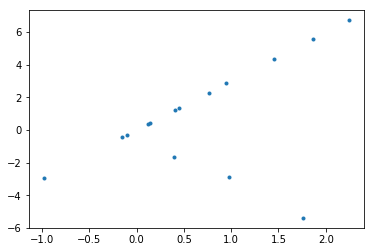

In [2]:
n = 15

np.random.seed(0)
x = np.random.randn(n)
y = 3*x
# add random outliers
Noutliers = 3
y[:Noutliers] = -3*(x[:Noutliers]+np.random.randn(Noutliers)*0.1)

# reshape
X = x[:,None]
X = np.concatenate((X, np.ones(n)[:,None]),axis=1)


# plot the points
plt.plot(x,y,'.');

No need to read the next code block. Waiting for JupyterLab and support for collapsing cells...

In [3]:
def plot_loss(loss_fun, X, y, wmin=-5, wmax=5, bmin=-5, bmax=5):
    m = 300
    w_lin = np.linspace(wmin, wmax, m)
    b_lin = np.linspace(bmin, bmax, m)
    w_grid, b_grid = np.meshgrid(w_lin, b_lin)
    w_flat = w_grid.flatten()
    b_flat = b_grid.flatten()
    
    pred = w_flat[None]*X[:,0][:,None] + b_flat[None]

    loss = np.sum(loss_fun(pred-y[:,None]),axis=0)
    if np.max(loss) > 1e5:
        print("Plotting log")
        loss = np.log(loss)
    loss_grid = np.reshape(loss,[m,m])

    CS = plt.contourf(w_grid, b_grid, loss_grid, nchunk=20)
    imin = np.argmin(loss_grid)
    plt.plot(w_flat[imin], b_flat[imin], 'r*', markersize=15)
    plt.xlabel('$w$')
    plt.ylabel('β')
    plt.clabel(CS, inline=1, fontsize=10)
#     plt.title('Loss in $w$-$β$ space')
#     plt.show()

def make_plots(error_fun):
    loss_fun = lambda w: np.sum(error_fun(X@w-y))
    plt.figure(figsize=(15,4))
    plt.clf()
    grid = np.linspace(-5,5,1000)
    plt.subplot(1,3,1)
    plt.plot(grid, error_fun(grid));
    plt.title('The loss on each residual')
    plt.xlabel("$r_i$")
    plt.ylabel("$f_i(r_i)$")
    plt.subplot(1,3,2)
    plot_loss(error_fun,X,y)
    w = minimize(loss_fun, npr.randn(2)).x
#     plt.scatter(w[0],w[1],s=200,facecolors='none',edgecolors='blue')
    plt.plot(w[0],w[1],'c*',markersize=15)
    plt.title('Loss contours in parameter space')
    plt.subplot(1,3,3)
    plt.plot(x,y,'.');
    plt.plot(x,X@w);
    plt.title('Fit model in data space')
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.tight_layout()
    return w

The squared loss:

$$f(w)=\sum_{i=1}^n (w^Tx_i-y_i)^2 = ||Xw-y||^2_2$$

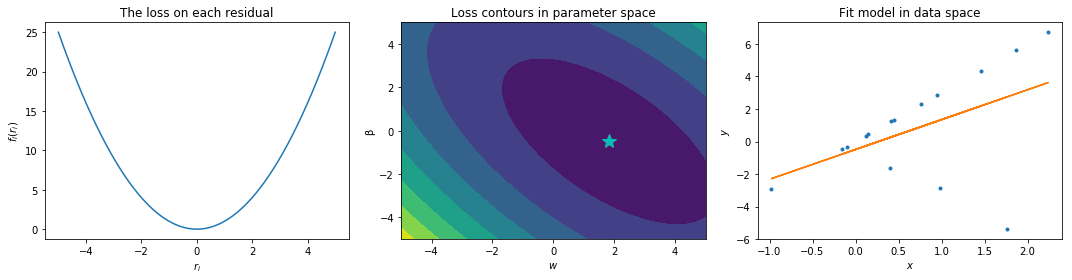

In [4]:
make_plots(np.square);

The absolute value loss:

$$f(w)=\sum_{i=1}^n |w^Tx_i-y_i| = ||Xw-y||_1$$

Or the Huber approximation.

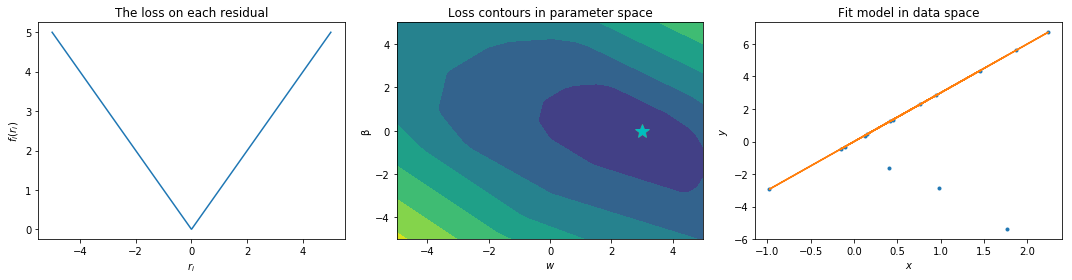

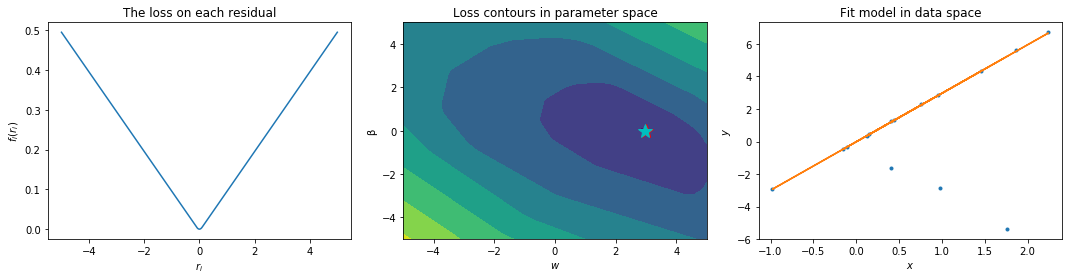

In [5]:
make_plots(np.abs);
make_plots(lambda r: scipy.special.huber(0.1,r));

(bonus) A non-convex "super-robust" loss:

$$f(w)=\sum_{i=1}^n |w^Tx_i-y_i|^{1/2} = ||Xw-y||_{1/2}$$

There are two problems here: non-smoothness AND non-convexity. Unlike the above cases, re-running the code yields different results because of the random initialization of the optimization procedure.

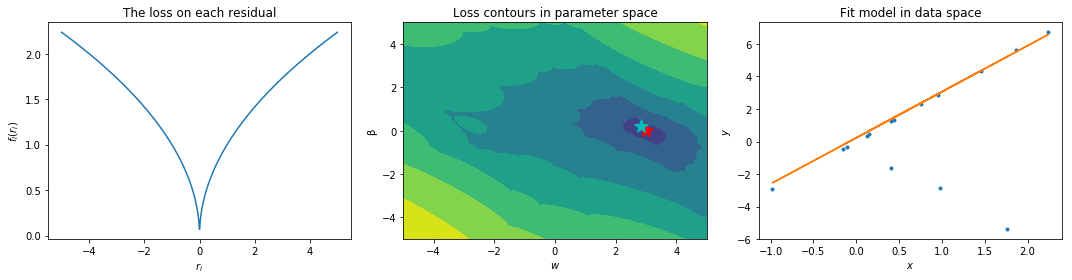

In [6]:
L12 = lambda z: np.sqrt(np.abs(z))
w = make_plots(L12)

The non-convex loss gives different results when I re-run `scipy.optimize.minimize`. Let's zoom in...

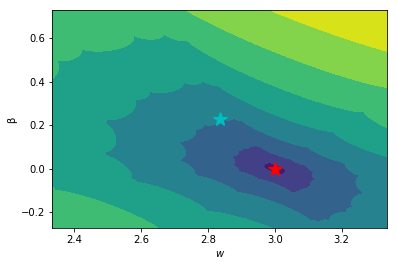

In [7]:
plot_loss(L12,X,y,wmin=w[0]-.5,wmax=w[0]+.5,bmin=w[1]-.5,bmax=w[1]+.5)
plt.plot(w[0],w[1],'c*',markersize=15);

(above) Conclusion: this looks like it's just a failure of the optimization method, rather than a local minimum?

Next, brittle regression (the opposite of robust):

$$f(w)=\max_{i=1,\ldots,n} |w^Tx_i-y_i| = ||Xw-y||_{\infty}$$

Or its smooth approximation:

$$f(w)=\log \sum_{i=1}^n \exp(|w^Tx_i-y_i|)$$

Plotting log


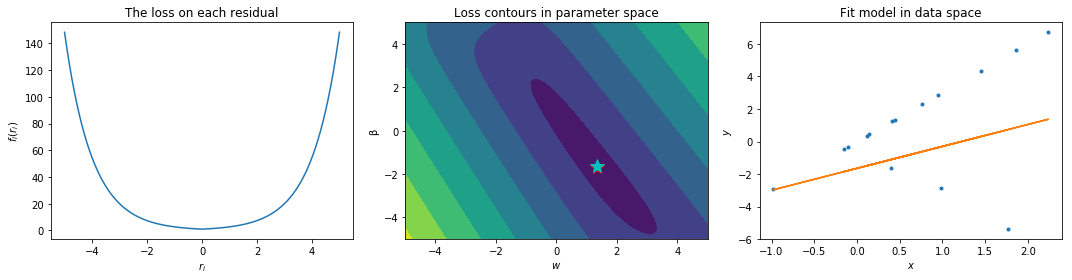

In [8]:
L_inf = lambda z: np.exp((np.abs(z)))
w = make_plots(L_inf)
# print(L_inf(X@w-y))

Notice the shape of the level sets. It says that if we want to increase the slope $w$ then we need to decrease the intercept $\beta$. In other words, we need to keep the predictions for large $x$ roughly the same because those predictions are, in a sense, the only ones that matter. (That would be true for the original infinity norm forumulation, but we've softened it).

-----------


## Polynomial features

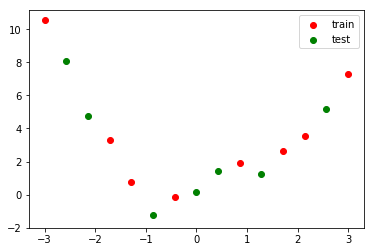

In [9]:
n = 15
x = np.linspace(-3,3,n)
y = x**2 + npr.randn(n)

xtrain,xvalid,ytrain,yvalid = train_test_split(x,y,test_size=7)

plt.scatter(xtrain,ytrain,c='red', label='train');
plt.scatter(xvalid,yvalid,c='green',label='test');
plt.legend();

p  |  train err   | valid err |
---+--------------+-----------+
0         87.5           71.1
1         85.8           68.3
2          5.1            7.9
3          2.3            5.3
4          2.0            5.7
5          0.3            5.5
6          0.0           14.1
7          0.0           12.7


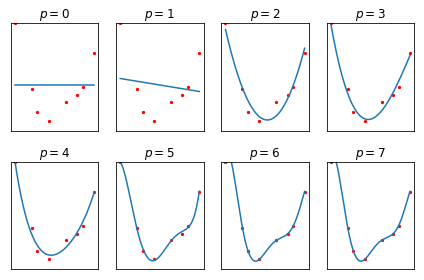

In [10]:
plt.figure()
plt.clf()

Xtrain = xtrain[:,None]
Xvalid = xvalid[:,None]

grid = np.linspace(np.min(x),np.max(x),1000)[:,None]

print("p  |  train err   | valid err |")
print("---+--------------+-----------+")
for p in range(8):
    pf = PolynomialFeatures(p)
    Z = pf.fit_transform(Xtrain)
    w = np.linalg.solve(Z.T @ Z, Z.T @ ytrain) # solve normal equations
    grid_poly = pf.fit_transform(grid)
    
    plt.subplot(2,4,p+1)
    plt.scatter(xtrain,ytrain,c='red', label='train',s=5);
#     plt.scatter(xvalid,yvalid,c='green',label='test',s=5);
    plt.plot(grid, grid_poly@w)
    train_pred = Z@w
    train_err = np.sum((ytrain-train_pred)**2)
    valid_pred = pf.transform(Xvalid)@w
    valid_err = np.sum((yvalid-valid_pred)**2)
    plt.title('$p=%d$'%p)
    plt.xticks(())
    plt.yticks(())
    plt.ylim((np.min(y),np.max(y)))
    print('%d %12.1f   %12.1f' % (p, train_err, valid_err))
plt.tight_layout();
#     print(max(abs(w)))
#     print(w)

In this case, based on the validation error, a degree of 2 or 3 both seem appropriate. Which is comforting, since we generated the data from a quadratic function ($p=2$). 

Question: can we penalize higher $p$ so that we'd definitely choose $p=2$ here?

## The basis function view

Our predictions are $y=Zv$. (We use the notation $v$ instead of $w$ when we've transformed our features into a new space.) Consider the column view of matrix multiplication:

$$ y_i = Zv= v_1 z_{i1} + v_2 z_{i2} + \ldots + v_d z_{id}$$

Now each $z^j$ is some function of the original $x$. For example, it might be different degree polynomials. So we can rewrite this as

$$ y_i = v_1 h_1(x_i) + v_2 h_2(x_i) + \ldots + v_d h_d(x_i)$$

where the $h_j$ are these different functions. These are called _basis functions_. We're not actually using the function as a continuous entity. Instead, we're evaluating it at the trainig points for training, and evaluating it at the test points for testing. 

## RBF features

[ 10.53277921   1.93707373   2.63647276   3.31693803   3.54328377
   7.29372981  -0.16423868   0.76527548]
0.01
[ 10.53277921   1.93707373   2.63610888   3.31685947   3.54301303
   7.29372981  -0.16423868   0.76493483]
0.1
[  9.83756474  -5.17026375  22.27443817   6.83920076 -25.59573928
  15.78197667   4.83799754 -10.74462684]
1.0
[   611020.46196492  -4240614.44251939   1135983.84624842
   3536297.35779249  -1100358.93327569    672275.7104      10653230.16169324
 -11266698.07270711]
10.0
[ -1.37007077e+07  -6.40943280e+07   1.15094613e+08   1.13061416e+08
  -2.34438380e+07  -1.13377732e+07  -6.29960687e+07  -5.25737155e+07]
100.0
[-588538.89110087  460571.14091869  137429.74701348   51524.00904731
 -500429.04561084 -376526.5485733   822751.27994416   -6782.89561747]
1000.0


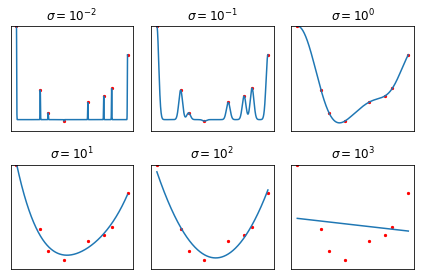

In [11]:
def euclidean_dist_squared(X, Xtest):
    return np.sum(X**2, axis=1)[:,None] + np.sum(Xtest**2, axis=1)[None] - 2 * np.dot(X,Xtest.T)
def RBF_features(Xtrain, Xtest, σ=1):
    return np.exp(-0.5*euclidean_dist_squared(Xtest,Xtrain)/σ**2)


count = 1
for log_σ_val in np.arange(-2,4):
    σ_val = 10.0**log_σ_val
    Z = RBF_features(Xtrain,Xtrain,σ=σ_val)
    w = np.linalg.solve(Z.T @ Z, Z.T @ ytrain) # solve normal equations    
    print(w)
    print(σ_val)
    plt.subplot(2,3,count)
    plt.scatter(xtrain,ytrain,c='red', label='train',s=5);
#     plt.scatter(xvalid,yvalid,c='green',label='test',s=5);

    grid_rbf = RBF_features(Xtrain,grid,σ=σ_val)
    plt.plot(grid, grid_rbf@w);
    plt.title('$σ=10^{%d}$'%log_σ_val)
    plt.xticks(())
    plt.yticks(())
    plt.ylim((np.min(y),np.max(y)))
    count += 1
plt.tight_layout();

This is not yet such a reasonable thing to do, especially for large $n$. (Well, it happens to work out nicely because the true data comes from a quadratic.) But the problem we're seeing here is that as we add complexity, we fit the data too aggressively. We'll take care of this in a couple lectures when we talk about regularization. But, as a preview, we'll try to get things that can be simultaneous complicated but not try too hard to fit the data.

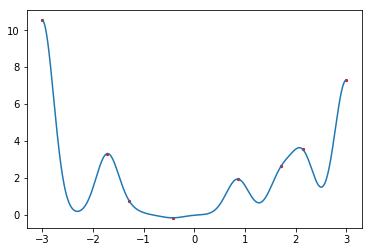

In [12]:
model = sklearn.kernel_ridge.KernelRidge(kernel="rbf",alpha=1e-5,gamma=10)
model.fit(Xtrain, ytrain)
plt.scatter(xtrain,ytrain,c='red', label='train',s=5);
plt.plot(grid, model.predict(grid));

In the above, `gamma` behaves roughly like $1/\sigma$ in our notation. And `alpha` is this thing called regularization which we will talk about, that I've turned off for now.

In the basis function view, we now have infinitely many basis functions. It's not that we're adding more basis functions as we decrease $\sigma$. Rather, we're making each basis function less smooth. When they are all super smooth they sort of blur into each other.